In [1]:
using Pkg 
Pkg.activate(".");

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using RxInfer
using Random, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets, LaTeXStrings  
using Zygote, Optim, ForwardDiff
using KernelFunctions, MAT, LoopVectorization
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix 
import ReactiveMP: approximate_meancov, WishartFast, approximate_kernel_expectation

In [3]:
import RxInfer: PointMassFormConstraint,call_boundaries, call_starting_point

In [12]:
include("New UniSGP.jl")

In [4]:
function predict_new(x_test,qv,qw,qθ,meta)
    prediction_y = @call_rule NewSGP(:out, Marginalisation) (q_in=PointMass(x_test),q_v = qv, q_w = qw,q_θ = qθ, meta=meta)
    return prediction_y
end

function predict_future_val(qx,qv,qw,qθ,meta)
    prediction_y = @call_rule NewSGP(:out, Marginalisation) (q_in=qx,q_v = qv, q_w = qw,q_θ = qθ, meta=meta)
    return prediction_y
end

function UpdateState(prior_prediction, observation)
    likelihood_update = @call_rule NormalMeanVariance(:μ, Marginalisation) (m_out = PointMass(observation), m_v = PointMass(var_y))
    x = ReactiveMP.prod(GenericProd(), prior_prediction, likelihood_update)
    return x
end

UpdateState (generic function with 1 method)

In [5]:
#Generate data 
Random.seed!(1471)
function generate_data(n,var_x,var_y)
    x_prev = 0.
    latent_state = Vector{Float64}(undef, n)
    observation = Vector{Float64}(undef,n)
    for i=1:n
        latent_state[i] = transition_func(x_prev) + sqrt(var_x) * randn()
        observation[i] = latent_state[i] + sqrt(var_y) * randn() 
        x_prev = latent_state[i]
    end
    return latent_state, observation 
end

N = 500 #number of data 
n_train = 300
n_test = N - n_train
var_x = 0.1
var_y = 0.01
transition_func = (x) -> 0.8 + (x + 0.2) * (1 - 5 / (1 + exp(-2*x)))

true_state, data = generate_data(N,var_x,var_y);
true_state_train = true_state[1:n_train]
true_state_test = true_state[n_train+1 : end];
data_train = data[1:n_train];
data_test = data[n_train+1:end];

In [6]:
@model function kink_model(y,Kuu)
    v ~ MvNormalMeanCovariance(zeros(size(Kuu,1)), Kuu)
    w ~ GammaShapeRate(0.01,0.01)
    x_prev ~ NormalMeanVariance(0, 50)
    θ ~ MvNormalMeanCovariance(zeros(2), 50*diageye(2))
    for i=1:length(y)
        x[i] ~ NewSGP(x_prev,v,w,θ)
        y[i] ~ NormalMeanVariance(x[i],var_y)
        x_prev = x[i]
    end
end

In [8]:
Nu = 20; #number of inducing points 
Xu = range(-4,1;length=Nu);
mean_gp = (x) -> 0
kernel_gp(θ) = exp(θ[1]) * with_lengthscale(Matern52Kernel(),exp(θ[2]))
Kuu = kernelmatrix(kernel_gp([0., 0.]),Xu) + 1e-7*I;
;

In [9]:
@meta function meta_kink_model(Xu,kernel)
    NewSGP() -> NewSGPMeta(Xu,nothing,kernel,nothing)
end

gp_constraint = @constraints begin
    q(x_prev,x,v,w,θ) = q(x)q(v)q(w)q(x_prev)q(θ)
    q(x) = q(x[begin])..q(x[end])
    q(θ) :: PointMassFormConstraint(starting_point = (args...) -> [log(1),log(1)])
end

gp_init = @initialization begin
    q(v) = MvNormalMeanCovariance(zeros(size(Kuu,1)),Kuu)
    q(x) = NormalMeanVariance(0,50)
    q(w) = GammaShapeRate(0.01,0.01)
    q(θ) = PointMass([0.,0.])
end
;

In [73]:
function RxInfer.default_point_mass_form_constraint_optimizer(::Type{Multivariate}, ::Type{Continuous}, constraint::PointMassFormConstraint, distribution)
    init_val = call_starting_point(constraint, distribution)
    target = let distribution = distribution
        (x) -> -logpdf(distribution, x)  
    end
    result = optimize(target, init_val, method = Optim.AdaMax(;alpha=1e-3),iterations=1)
    return PointMass(result.minimizer)
end

struct Realsupport 
    dim
end

function Base.in(x, ::Realsupport)
    return true
end

function BayesBase.support(dist::MvNormalMeanCovariance)
    return Realsupport(length(mean(dist)))
end

In [74]:
niter = 1;

infer_result = infer(
    model = kink_model(Kuu = Kuu,),
    iterations = niter,
    data = (y = data_train,),
    initialization = gp_init,
    constraints = gp_constraint,
    meta = meta_kink_model(Xu,kernel_gp),
    returnvars = (x = KeepLast(), v = KeepLast(),w = KeepLast(),θ = KeepLast(),),
    free_energy = true,
    showprogress = false
) 

ForwardDiff.gradient(target, [1, 1]) = [NaN, NaN]
ForwardDiff.gradient(target, [1, 1]) = [NaN, NaN]


Inference results:
  Posteriors       | available for (w, v, θ, x)
  Free Energy:     | Real[906.99]


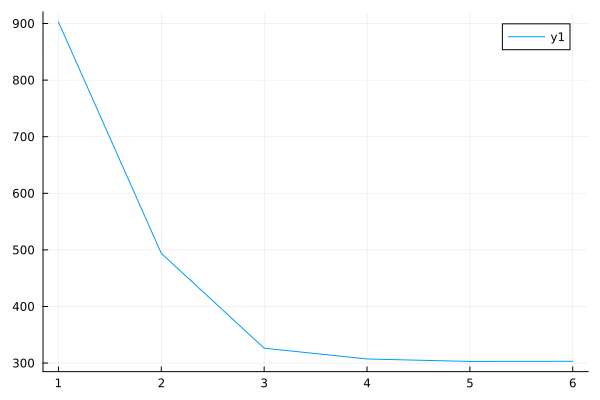

In [57]:
plot(infer_result.free_energy)

In [58]:
qv_gp = infer_result.posteriors[:v]
qx_gp = infer_result.posteriors[:x];
qw_gp = infer_result.posteriors[:w];
qθ_gp = infer_result.posteriors[:θ];


In [59]:
exp.(mean(qθ_gp))

2-element Vector{Float64}:
 1.133066719877297
 0.889479958705908

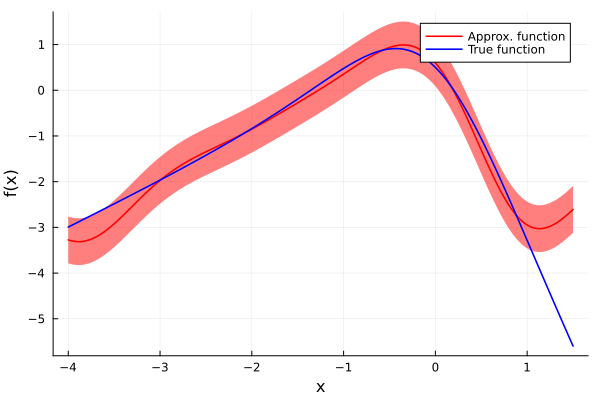

In [60]:
X = collect(-4:0.01:1.5)
predict_mean =[]
predict_var =[]
for i=1:length(X)
    prediction = predict_new(X[i],qv_gp,qw_gp,qθ_gp,NewSGPMeta(Xu,nothing,kernel_gp,nothing))
    append!(predict_mean,mean(prediction))
    append!(predict_var,var(prediction)) 
end

plot(X,predict_mean,ribbon = sqrt.(predict_var .+ 1e-7),
    label="Approx. function",lw=1.6, legend=:topright,
    color=:red)

plot!(X,transition_func.(X),label="True function",
    lw=1.6,
    color=:blue)
xlabel!("x")
ylabel!("f(x)")

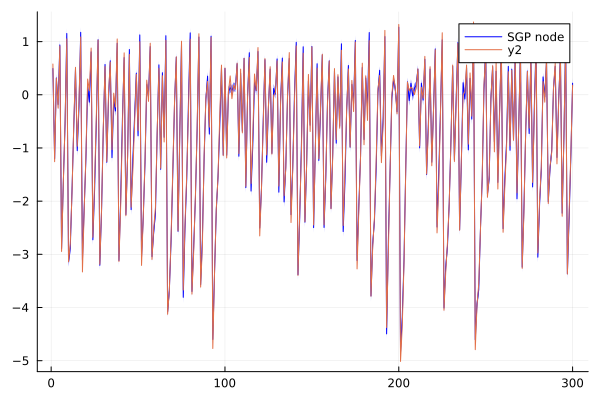

In [61]:
plot(mean.(qx_gp), 
    ribbon = sqrt.(var.(qx_gp)),label="SGP node",lw=1, legend=:topright,
    color=:blue)
plot!(true_state_train)

In [62]:
# compare prediction
## by GP
predict_future = []
var_predict_future = []
prev_state = qx_gp[end]
for i=1:100
    prediction = predict_future_val(prev_state,qv_gp,qw_gp,qθ_gp, NewSGPMeta(Xu,nothing,kernel_gp,nothing))
    append!(predict_future,mean(prediction))
    append!(var_predict_future,var(prediction)) 
    prev_state = UpdateState(prediction,data_test[i])
end

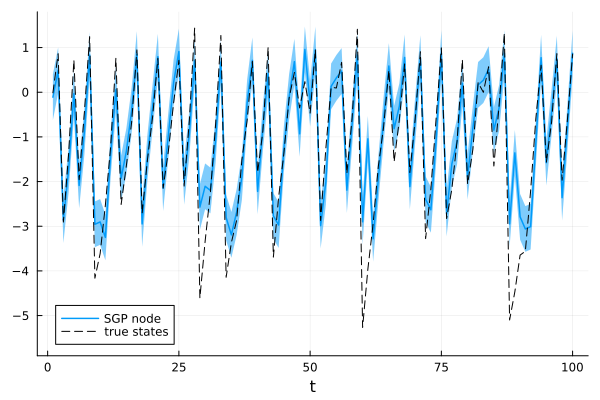

In [63]:

plot(predict_future,ribbon=sqrt.(var_predict_future),label="SGP node", lw=1.5,ylims=(-5.9,1.8))
plot!(true_state_test[1:100],label="true states", ls=:dash, color=:black)
xlabel!("t")